In [29]:
import matplotlib.pyplot as plt
import numpy
import tensorflow as tf
import tensorflow_datasets as tfds

In [30]:
ds = tfds.load('mnist', split='train', shuffle_files=False)
assert isinstance(ds, tf.data.Dataset)
print(ds)

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [31]:
train_images = []
train_labels = []
for example in ds:
  train_images.append(example["image"])
  train_labels.append(example["label"])

In [32]:
X = numpy.array(train_images)
y = numpy.array(train_labels)

Examples for classes

In [33]:
from collections import Counter
count = Counter(y)
count

Counter({0: 5923,
         1: 6742,
         2: 5958,
         3: 6131,
         4: 5842,
         5: 5421,
         6: 5918,
         7: 6265,
         8: 5851,
         9: 5949})

Extract examples of class 2, 3 and 4

In [34]:
examples = []
count = numpy.zeros((3,))
for i in range(len(X)):
    if y[i] == 2 and count[0] <=200:
      examples.append(X[i])
      count[0]+=1
    elif y[i] == 3 and count[1] <= 200:
      examples.append(X[i])
      count[1]+=1
    elif y[i] == 4 and count[2] <= 200:
      examples.append(X[i])
      count[2]+=1
    if numpy.sum(count) == 600:
      break

Normalizing the values and assigning bernoulli random variable

In [36]:
examples_array = numpy.array(examples)/255
examples_array = examples_array.reshape(examples_array.shape[0], 784)
# examples_array[0]

In [37]:
X = numpy.where(examples_array > 0.5, 1, 0)
# X[0]

Assigning intial values to parameters for estimating class conditional densities


In [38]:
PI = numpy.array([1/3, 1/3, 1/3])
# PI

Assigning random values to means

In [39]:
random_MU = 0.5*numpy.random.random((3,784)) + 0.25
# random_MU

Normalizing Mean

In [40]:
MU = random_MU/numpy.sum(random_MU, axis=1)[:, None]
# MU

In [41]:
def prob_x_given_mu(x, mu):
  temp = 1
  for i in range(len(x)):
    temp *= ((mu[i])**(x[i]))*((1-mu[i])**(1-x[i]))
  # tried log
  # for i in range(len(x)):
  #   temp += x[i]*numpy.log(mu[i]) + (1-x[i])*numpy.log(1-mu[i])
  return temp

def posterior_z(x, MU, PI, i):
  numerator = PI[i]*prob_x_given_mu(x, MU[i])
  denominator = 0
  for j in range(len(MU)):
    denominator += PI[j]*prob_x_given_mu(x, MU[j])
    # print(PI[j]*prob_x_given_mu(x, MU[j]))
  # print("printed num", numerator)
  # print("printed denom", denominator)
  if numerator == 0:
    return 0
  else:
    return numerator/denominator

def complete_data_log_likelihood(X, MU, PI, Z):
  temp = 0
  for i in range(len(X)):
    for j in range(len(MU)):
      dim_sum = 0
      for k in range(len(MU[j])):
        dim_sum += (X[i][k]*numpy.log(MU[j][k])) + ((1-X[i][k])*numpy.log(1-MU[j][k]))
      temp += Z[i][j]*(numpy.log(PI[j]) + dim_sum)
  return temp

def posterior_assignment(i, Z):
  N_i = 0
  for j in range(len(Z)):
    N_i += Z[j][i]
  # print(N_i)
  return N_i

def update_mu(X, MU, PI, i, Z):
  mu_i = numpy.zeros(MU[i].shape[0],)
  for j in range(len(X)):
    mu_i += Z[j][i] * X[j]
  return mu_i/posterior_assignment(i, Z)

def update_pi(X, MU, PI, i, Z):
  return posterior_assignment(i, Z)/Z.shape[0]

In [42]:
Z = numpy.zeros((X.shape[0],MU.shape[0]))
MU_updated = numpy.zeros((MU.shape[0], MU.shape[1]))
PI_updated = numpy.zeros((PI.shape[0],))

In [43]:
len(X)
likelihood = []

# EM Algorithm

In [44]:
for i in range(10):
  # E step
  # Calculate posterior
  print("itr",i)
  for j in range(len(X)):
    for k in range(len(MU)):
        Z[j][k] = posterior_z(X[j], MU, PI, k)
  # Calulate Log Likelihood
  likelihood.append(complete_data_log_likelihood(X, MU, PI, Z))
  # print("Complete Data Log Likelihood", complete_data_log_likelihood(X, MU, PI, Z))
  # M step
  for k in range(len(MU)):
    MU_updated[k] = update_mu(X, MU, PI, k, Z) + (numpy.ones((len(MU_updated[k]),))*1e-90)
  for k in range(len(PI)):
    PI_updated[k] = update_pi(X, MU, PI, k, Z)
  MU = MU_updated
  PI = PI_updated

itr 0
itr 1
itr 2
itr 3
itr 4
itr 5
itr 6
itr 7
itr 8
itr 9


Plot for Likelihood vs iteartions

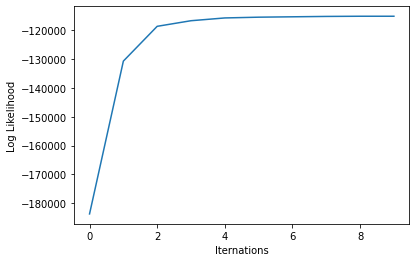

In [45]:
itr = numpy.arange(10)
import matplotlib.pyplot as plt
plt.plot(itr, likelihood)
plt.xlabel('Iternations')
plt.ylabel('Log Likelihood')
plt.show()

Plotting images

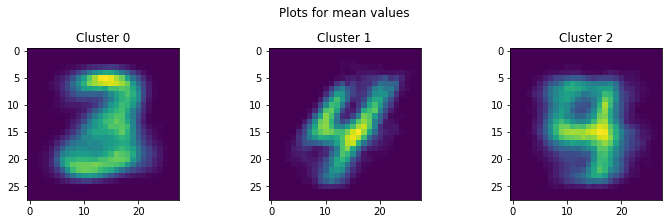

In [46]:
fig,axs = plt.subplots(1,3, figsize=(10,3), constrained_layout=True)
mu_images = (MU/numpy.max(MU, axis=1)[:, numpy.newaxis])*255
mu_images = mu_images.reshape(3, 28, 28)
fig.suptitle("Plots for mean values")

for i in range(3):
  axs[i].imshow(mu_images[i])
  axs[i].set_title("Cluster " + str(i)  )
plt.show()

# Kmeans Algorithm

In [47]:
X = numpy.where(examples_array > 0.5, 1, 0)
# Randomized Means
random_MU = 0.5*numpy.random.random((3,784)) + 0.25
MU = random_MU/numpy.sum(random_MU, axis=1)[:, None]

In [48]:
def calculate_euclidean(x, MU):
  distance = numpy.zeros((MU.shape[0],))
  for i in range(len(MU)):
    distance[i] = numpy.linalg.norm(x-MU[i])
  return distance

In [49]:
Z = numpy.zeros((X.shape[0],))
euc_dist = numpy.zeros((X.shape[0], MU.shape[0]))
for i in range(10):
  # calculating distance and find min
  for j in range(len(X)):
    euc_dist[j] = calculate_euclidean(X[j], MU)
    Z[j] = numpy.argmin(euc_dist[j])
  # recompute the mean
  for j in range(len(MU)):
    MU[j] = numpy.sum(X[Z==j], axis=0)/X[Z==j].shape[0]

Plotting Images

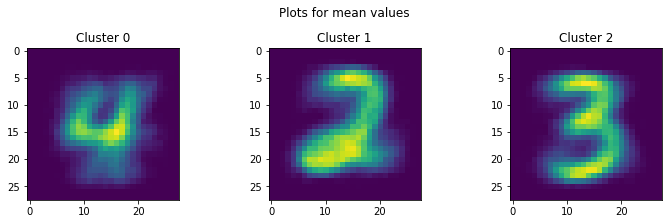

In [50]:
fig,axs = plt.subplots(1,3, figsize=(10,3), constrained_layout=True)
mu_images = (MU/numpy.max(MU, axis=1)[:, numpy.newaxis])*255
mu_images = mu_images.reshape(3, 28, 28)
fig.suptitle("Plots for mean values")

for i in range(3):
  axs[i].imshow(mu_images[i])
  axs[i].set_title("Cluster " + str(i) )
plt.show()

# Single Mutivariate Bernoulli

Text(0.5, 1.0, 'Cluster')

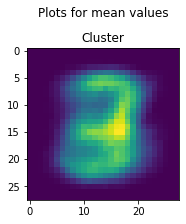

In [51]:
# Average of the pixels

MU = numpy.sum(X, axis=0)/len(X)
fig,axs = plt.subplots(1,1, figsize=(20,3), constrained_layout=True)
mu_images = MU.reshape(28, 28)
fig.suptitle("Plots for mean values")

axs.imshow(mu_images)
axs.set_title("Cluster")

# Gradient Descent

In [52]:
X = numpy.where(examples_array > 0.5, 1, 0)

In [53]:
# parameters

PI = numpy.ones((3,))*0.33
random_MU = 0.5*numpy.random.random((3,784)) + 0.25
MU = random_MU/numpy.sum(random_MU, axis=1)[:, None]
X = numpy.where(examples_array > 0.5, 1, 0)
gamma = numpy.zeros((len(X), len(MU)))
gradient_mu = numpy.zeros((len(MU), MU.shape[1]))
gradient_lambda = numpy.zeros((len(MU),))
# random means


In [54]:
# Gradient descent for multivariate bernoulli

def prob_x_given_mu(x, mu):
  temp = 1
  for i in range(len(x)):
    temp *= ((mu[i])**(x[i]))*((1-mu[i])**(1-x[i]))
  # tried log
  # for i in range(len(x)):
  #   temp += x[i]*numpy.log(mu[i]) + (1-x[i])*numpy.log(1-mu[i])
  return temp

def calculate_gamma(x, PI, MU, j):
  numerator = PI[j]*prob_x_given_mu(x, MU[j])
  denominator = 0
  for j in range(len(MU)):
    denominator += PI[j]*prob_x_given_mu(x, MU[j])
    # print(PI[j]*prob_x_given_mu(x, MU[j]))
  # print("printed num", numerator)
  # print("printed denom", denominator)
  if numerator == 0:
    return 0
  else:
    return numerator/denominator

def calculate_gradient_mu(X, MU, gamma, j, t):
  numerator = 0
  for i in range(len(X)):
    numerator += gamma[i][j]*(X[i][t] + MU[j][t] - 2*X[i][t]*MU[j][t])
  denominator = MU[j][t]*(1-MU[j][t])
  return numerator/denominator

def calculate_gradient_lambda(gamma, PI, j):
  numerator = 0
  for i in range(len(gamma)):
    numerator += gamma[i][j]
  denominator = PI[j]
  return numerator/denominator

def data_likelihood(X, MU, PI):
  likelihood = 0
  for i in range(len(X)):
    temp = 0
    for j in range(len(MU)):
      temp += PI[j]*prob_x_given_mu(X[i], MU[j])
    # print("temp", temp)
    if temp <= 0:
      for j in range(len(MU)):
        print("value for j={value}".format(value =j), prob_x_given_mu(X[i], MU[j]))
        # print("x", X[i])
        # print("mu", MU[j])
        print(PI[j]*prob_x_given_mu(X[i], MU[j]))
    likelihood += numpy.log(temp)

  return likelihood

In [55]:
const = 0.0001
for i in range(30):
  # Calculate gamma
  for i in range(len(X)):
    for j in range(len(MU)):
      gamma[i][j] = calculate_gamma(X[i], PI, MU, j)
  # Calculate gradients
  for j in range(len(MU)):
    for t in range(MU.shape[1]):
      gradient_mu[j][t] = calculate_gradient_mu(X, MU, gamma, j, t)
    gradient_lambda[j] = calculate_gradient_lambda(gamma, PI, j)
  # Adjust parametersoptimize.curve_fi
  # Calculate gradients
  for j in range(len(MU)):
    for t in range(MU.shape[1]):
      MU[j][t] = MU[j][t] + (const*gradient_mu[j][t])
    PI[j] = PI[j] + (const*gradient_lambda[j])
  likelihood_PI = PI
  PI = likelihood_PI/numpy.sum(likelihood_PI)
  # Scale to 0-1
  print(PI)
  for j in range(len(MU)):
    MU[j] = (MU[j] - numpy.min(MU[j]))/(numpy.max(MU[j])-numpy.min(MU[j]))
  MU = MU*0.5 + 0.25
  # Data likelihood
  print("data likelihood", data_likelihood(X, MU, PI)) 
  

[0.3336524  0.33774134 0.32860627]
data likelihood -200236.39145592123
[0.33199504 0.35348923 0.31451573]
data likelihood -200599.35108532954
[0.33410288 0.36190714 0.30398998]
data likelihood -200990.1239866724
[0.33756368 0.36527433 0.29716198]
data likelihood -201403.90509398686
[0.34084633 0.36531875 0.29383492]
data likelihood -201836.8052928697
[0.3431861  0.36330417 0.29350974]
data likelihood -202285.41632619468
[0.34432066 0.36006497 0.29561438]
data likelihood -202746.21864259712
[0.34425422 0.35587729 0.29986849]
data likelihood -203213.76908043202
[0.34313131 0.35074764 0.30612105]
data likelihood -203680.1714903598
[0.34140904 0.34472923 0.31386173]
data likelihood -204027.06024192038
[0.34154422 0.33860077 0.31985501]
data likelihood -204361.64049779868
[0.34303156 0.33271567 0.32425277]
data likelihood -204695.13801669702
[0.34564236 0.32701587 0.32734176]
data likelihood -205027.78331276614
[0.34922265 0.32140352 0.32937384]
data likelihood -205359.59949117847
[0.353627

In [56]:
# Scale to 0-1
for j in range(len(MU)):
  MU[j] = (MU[j] - numpy.min(MU[j]))/(numpy.max(MU[j])-numpy.min(MU[j]))

Plotting Images

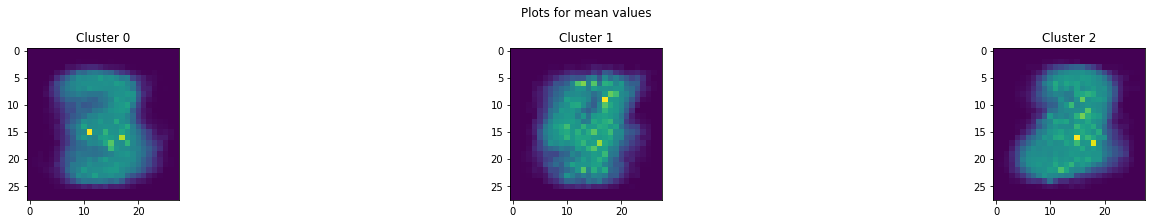

In [57]:
fig,axs = plt.subplots(1,3, figsize=(20,3), constrained_layout=True)
mu_images = (MU/numpy.max(MU, axis=1)[:, numpy.newaxis])*255
mu_images = mu_images.reshape(3, 28, 28)
fig.suptitle("Plots for mean values")

for i in range(3):
  axs[i].imshow(mu_images[i])
  axs[i].set_title("Cluster " + str(i) )
plt.show()

In [58]:
(MU/numpy.max(MU, axis=1)[:, numpy.newaxis])[0]*255

array([8.00498103e-03, 2.21845036e-02, 5.13516420e-03, 1.58927981e-03,
       1.46288301e-02, 2.21279589e-02, 2.37336692e-02, 7.96503604e-03,
       7.12602005e-03, 1.85027205e-02, 1.50535635e-02, 1.90222534e-02,
       4.36109553e-03, 1.08827122e-02, 1.78009364e-02, 1.58639577e-02,
       1.59762655e-02, 4.88802616e-03, 2.17505235e-02, 8.73414504e-03,
       1.38124692e-02, 3.36342153e-03, 5.77255582e-03, 2.10358686e-03,
       2.10786958e-02, 1.67790041e-02, 5.13716715e-04, 1.00431847e-03,
       2.29210982e-02, 2.11618156e-02, 2.07601099e-02, 1.87153734e-02,
       2.06833967e-02, 2.26228069e-02, 1.12674791e-02, 1.14689122e-03,
       2.16256937e-02, 1.92112695e-02, 1.47564832e-03, 1.01303775e-02,
       2.99281910e-03, 1.41813847e-02, 2.35760550e-02, 1.50242894e-02,
       5.65409752e-03, 5.18997813e-05, 8.30012757e-03, 2.40005172e-02,
       1.95336371e-02, 1.01606597e-02, 1.25530167e-02, 1.85739973e-02,
       1.36780222e-02, 1.25109252e-02, 2.45139731e-03, 2.80025280e-03,
      